In [1]:
#importing libraries

import os
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Function to load RAVDESS dataset
def load_ravdess_dataset(dataset_path):
    data = {'path': [], 'emotion': []}

    # Iterate over actor folders
    for actor_folder in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor_folder)

        if os.path.isdir(actor_path):
            # Iterate over audio files in each actor folder
            for audio_file in os.listdir(actor_path):
                audio_path = os.path.join(actor_path, audio_file)

                # Extract emotion from the file name (assuming file names are structured)
                emotion = int(audio_file.split('-')[2])

                # Append data to the dictionary
                data['path'].append(audio_path)
                data['emotion'].append(emotion)

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(data)
    
    return df

# path to the dataset
dataset_path = r'C:\\Users\\chethan\\Downloads\\RIC\\audio_speech_actors_01-24'

# Loading the dataset
ravdess_dataset = load_ravdess_dataset(dataset_path)


In [2]:
#This shows the number of records in the dataset
print(ravdess_dataset.info())
print(ravdess_dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     1440 non-null   object
 1   emotion  1440 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.6+ KB
None
(1440, 2)


In [3]:
# Displaying the loaded dataset
print(ravdess_dataset.head())

                                                path  emotion
0  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1
1  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1
2  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1
3  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1
4  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        2


In [5]:
# Mapping emotion labels to stress levels
stress_mapping = {
    1: 'low_stress',
    2: 'low_stress',
    3: 'low_stress',
    4: 'low_stress',
    5: 'high_stress',
    6: 'high_stress',
    7: 'high_stress',
    8: 'high_stress',
}

ravdess_dataset['stress_level'] = ravdess_dataset['emotion'].map(stress_mapping)


In [6]:
# Displaying the loaded dataset
print(ravdess_dataset.head())

                                                path  emotion stress_level
0  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
1  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
2  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
3  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        1   low_stress
4  C:\\Users\\chethan\\Downloads\\RIC\\audio_spee...        2   low_stress


In [7]:
# Getting the count of stress levels
high_stress_count_audio = ravdess_dataset[ravdess_dataset['stress_level'] == 'high_stress'].shape[0]
low_stress_count_audio = ravdess_dataset[ravdess_dataset['stress_level'] == 'low_stress'].shape[0]

print("Number of High Stressed Instances in Audio Dataset:", high_stress_count_audio)
print("Number of Low Stressed Instances in Audio Dataset:", low_stress_count_audio)

Number of High Stressed Instances in Audio Dataset: 768
Number of Low Stressed Instances in Audio Dataset: 672


In [8]:
# Function to extract features from audio files
def extract_features(file_path):
    try:
        # Loading audio file with librosa
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Extracting features using librosa
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sample_rate), axis=1)

        # Combining all features into a single array
        feature_array = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}. Error: {e}")
        return None

    return feature_array

In [9]:
# Extracting features from each audio file and create a DataFrame
!pip install resampy
ravdess_dataset['features'] = ravdess_dataset['path'].apply(extract_features)


C:\Users\chethan\anaconda3\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


In [10]:
# Dropping rows with missing features
ravdess_dataset = ravdess_dataset.dropna()


In [11]:
# Converting features to a list and labels to a NumPy array
X = np.array(ravdess_dataset['features'].tolist())
y = np.array(ravdess_dataset['stress_level'])

In [12]:
# Encoding the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [13]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


In [14]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Building the neural network model
model = Sequential()
model.add(Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [16]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [17]:
# Training the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
29/29 [==============================] - 3s 28ms/step - loss: 0.7868 - accuracy: 0.5657 - val_loss: 0.5908 - val_accuracy: 0.6970
Epoch 2/50
29/29 [==============================] - 0s 7ms/step - loss: 0.6348 - accuracy: 0.6558 - val_loss: 0.5540 - val_accuracy: 0.7273
Epoch 3/50
29/29 [==============================] - 0s 7ms/step - loss: 0.5806 - accuracy: 0.6840 - val_loss: 0.5339 - val_accuracy: 0.7403
Epoch 4/50
29/29 [==============================] - 0s 7ms/step - loss: 0.5570 - accuracy: 0.7123 - val_loss: 0.5156 - val_accuracy: 0.7446
Epoch 5/50
29/29 [==============================] - 0s 7ms/step - loss: 0.5355 - accuracy: 0.7438 - val_loss: 0.5071 - val_accuracy: 0.7619
Epoch 6/50
29/29 [==============================] - 0s 7ms/step - loss: 0.4979 - accuracy: 0.7557 - val_loss: 0.4875 - val_accuracy: 0.7792
Epoch 7/50
29/29 [==============================] - 0s 9ms/step - loss: 0.4984 - accuracy: 0.7633 - val_loss: 0.4818 - val_accuracy: 0.7835
Epoch 8/50
29/29 [=

In [18]:
# Making predictions on the test set
y_pred = model.predict(X_test_scaled)

9/9 [==============================] - 0s 5ms/step


In [19]:
# Convertting predictions to class labels
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_test_labels = le.inverse_transform(np.argmax(y_test, axis=1))

In [20]:
# Evaluate the model
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))

Classification Report:
               precision    recall  f1-score   support

 high_stress       0.83      0.87      0.85       151
  low_stress       0.85      0.80      0.82       137

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.84      0.84      0.84       288

Accuracy: 0.8368055555555556


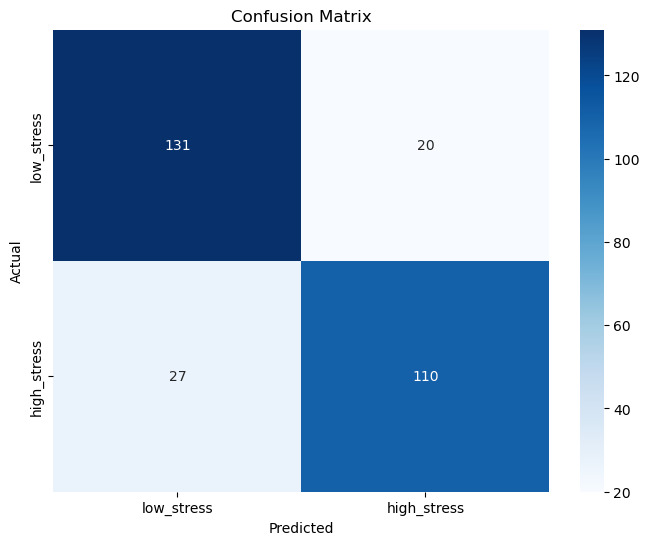

In [21]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['low_stress', 'high_stress'], yticklabels=['low_stress', 'high_stress'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# ROC Curve
fpr, tpr, thresholds = roc_curve((y_test_labels == 'high_stress').astype(int), (y_pred_labels == 'high_stress').astype(int))
roc_auc = auc(fpr, tpr)

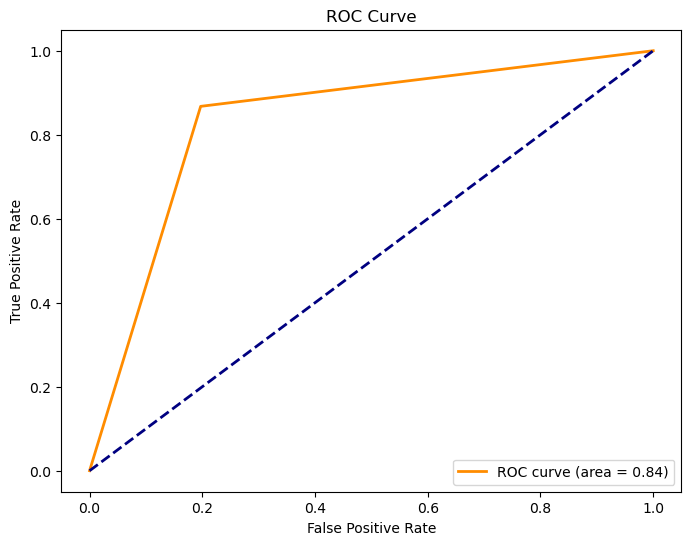

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
from joblib import dump

# Save the audio model
save_path = 'C:/Users/chethan/Downloads/RIC/audio_model_saved.joblib'
dump(model, save_path)

print(f"Audio model saved successfully at: {save_path}")

Audio model saved successfully at: C:/Users/chethan/Downloads/RIC/audio_model_saved.joblib
